# Text Generator based on next character prediction

Made using a simple 2 Hidden layered Neural Network, this text generator can predict next characters of the input text provided.

This app aims at showing how a Neural Network is also capable of capturing the format of English language, and generate words that are very close to valid words. Notice that the model uses capital letters (including capital I), punctuation marks and fullstops nearly correct. The text is generated paragraph wise, because the model learnt this from the text corpus.

This model was trained on a simple 4.52MB text corpus titled: 'Shakespeare.txt'

Streamlit application: [Link](https://nextchar191.streamlit.app/)

This notebook contains a simple text generator that predicts the next character based on the previous k characters

In [ ]:
# !pip uninstall -y triton
!pip install triton

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [ ]:
torch.__version__

'2.5.0+cu121'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## Read the text corpus

The model is trained on the 600 KB text corpus titled: 'Gulliver's Travels'. This is available in the repository in a file named gt.txt .

In [ ]:
with open('Shakespeare.txt', 'r') as file:
    thefile = file.read()

In [ ]:
content = thefile[:-2000]
test = thefile[-2000:]

In [ ]:
len(content), len(test)

(4571337, 2000)

In [ ]:
print(type(content))

<class 'str'>


## Create a dictionary to store unique characters and their indices

In [ ]:
stoi = {}
stoi['@'] = 0
i = 1
for char in sorted(content):
    if char not in stoi:
        stoi[char] = i
        i+=1

print(stoi)

{'@': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, '[': 40, ']': 41, 'a': 42, 'b': 43, 'c': 44, 'd': 45, 'e': 46, 'f': 47, 'g': 48, 'h': 49, 'i': 50, 'j': 51, 'k': 52, 'l': 53, 'm': 54, 'n': 55, 'o': 56, 'p': 57, 'q': 58, 'r': 59, 's': 60, 't': 61, 'u': 62, 'v': 63, 'w': 64, 'x': 65, 'y': 66, 'z': 67}


In [ ]:
itos = {value: key for key, value in stoi.items()}

print(itos)

{0: '@', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: '[', 41: ']', 42: 'a', 43: 'b', 44: 'c', 45: 'd', 46: 'e', 47: 'f', 48: 'g', 49: 'h', 50: 'i', 51: 'j', 52: 'k', 53: 'l', 54: 'm', 55: 'n', 56: 'o', 57: 'p', 58: 'q', 59: 'r', 60: 's', 61: 't', 62: 'u', 63: 'v', 64: 'w', 65: 'x', 66: 'y', 67: 'z'}


## Set the block size

In [ ]:
# context length: how many characters we can take to predict the next one.

block_size = 50
# block_size = 15

X, Y = [], []
for i in range(len(content)-block_size-2):
  X.append([stoi[x] for x in content[i:i+block_size]])
  Y.append(stoi[content[i+block_size]])

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

### Training data X and Y

In [ ]:
X

tensor([[19, 50, 59,  ..., 46, 42, 59],
        [50, 59, 60,  ..., 42, 59,  2],
        [59, 60, 61,  ..., 59,  2, 54],
        ...,
        [ 2, 64, 42,  ..., 46, 55,  2],
        [64, 42, 50,  ..., 55,  2, 61],
        [42, 50, 61,  ...,  2, 61, 49]], device='cuda:0')

In [ ]:
Y

tensor([ 2, 54, 46,  ..., 61, 49, 66], device='cuda:0')

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([4571285, 50]), torch.int64, torch.Size([4571285]), torch.int64)

## Set the Embedding size

In [ ]:
# Embedding layer for the context

# emb_dim = 64
emb_dim = 32
# emb_dim = 15
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [ ]:
emb.weight.shape

torch.Size([68, 32])

## Visualizing the embedding

In [ ]:
# # # Function to visualize the embedding in 2d space if 2 dimensions are used

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

if emb_dim == 2:
  plot_emb(emb, itos)

## Neural Network Model

In [ ]:
actFuncDict = {0 : "sin", 1 : "relu", 2 : "tanh"}


In [ ]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    # x = torch.tanh(self.lin1(x)) # Activation function
    # x = torch.tanh(self.lin2(x))
    # x = torch.sin(self.lin1(x)) # Activation function
    # x = torch.sin(self.lin2(x))
    x = torch.relu(self.lin1(x)) # Activation function
    x = torch.relu(self.lin2(x))
    x = self.lin3(x)
    return x

## Generate text from the untrained model

In [ ]:
# Enable high precision for float32 matrix multiplications
torch.set_float32_matmul_precision('high')


In [ ]:
model = NextChar(block_size, len(stoi), emb_dim, 500, 300).to(device)
model = torch.compile(model)

no_of_chars = 200
g = torch.Generator()
g.manual_seed(200)

def generate_text(model, inp, itos, stoi, block_size, max_len=no_of_chars):
    context = [0] * block_size
    # inp = inp.lower()
    if len(inp) <= block_size:
      for i in range(len(inp)):
        context[i] = stoi[inp[i]]
    else:
      j = 0
      for i in range(len(inp)-block_size,len(inp)):
        context[j] = stoi[inp[i]]
        j+=1

    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        if ix in itos:
          ch = itos[ix]
          name += ch
          context = context[1:] + [ix]
    return name

print(generate_text(model, "@", itos, stoi, block_size, no_of_chars))

FC3vCC]
fyhp]ZTMgXrblD&kayMet&
cPojyeyrE],]c]JMeRnUyYf.oGUPk@p,XEKGwST]Nsm,sUO?
?Ie.tiYM?qg:.ExwCOxv$?geThu]GqUTEj?O?@uv-,tUvMx[shHx :Mos$Dw

G,Rgo@ebaSUNZjIksrj3?-sbkeUlwbLE,i[@QeogVs3,RR:uoT
qwIBZAr


### Shapes of model's weights and biases

In [ ]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([68, 32])
_orig_mod.lin1.weight torch.Size([500, 1600])
_orig_mod.lin1.bias torch.Size([500])
_orig_mod.lin2.weight torch.Size([300, 500])
_orig_mod.lin2.bias torch.Size([300])
_orig_mod.lin3.weight torch.Size([68, 300])
_orig_mod.lin3.bias torch.Size([68])


## Train the model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 10
elapsed_time = []
loss_arr = []
for epoch in range(200):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    loss_arr.append(loss.item())
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 1.82537841796875
10 1.5893088579177856
20 1.566052794456482
30 1.4907418489456177
40 1.4679625034332275
50 1.445299744606018
60 1.4156146049499512
70 1.4030760526657104
80 1.4139080047607422
90 1.4113441705703735
100 1.3577378988265991
110 1.332809567451477
120 1.3243870735168457
130 1.3129349946975708
140 1.3050566911697388
150 1.3021743297576904
160 1.2965354919433594
170 1.2386983633041382
180 1.300620675086975
190 1.2540156841278076


# Visualizing embeddings in higher dimensions using t-SNE

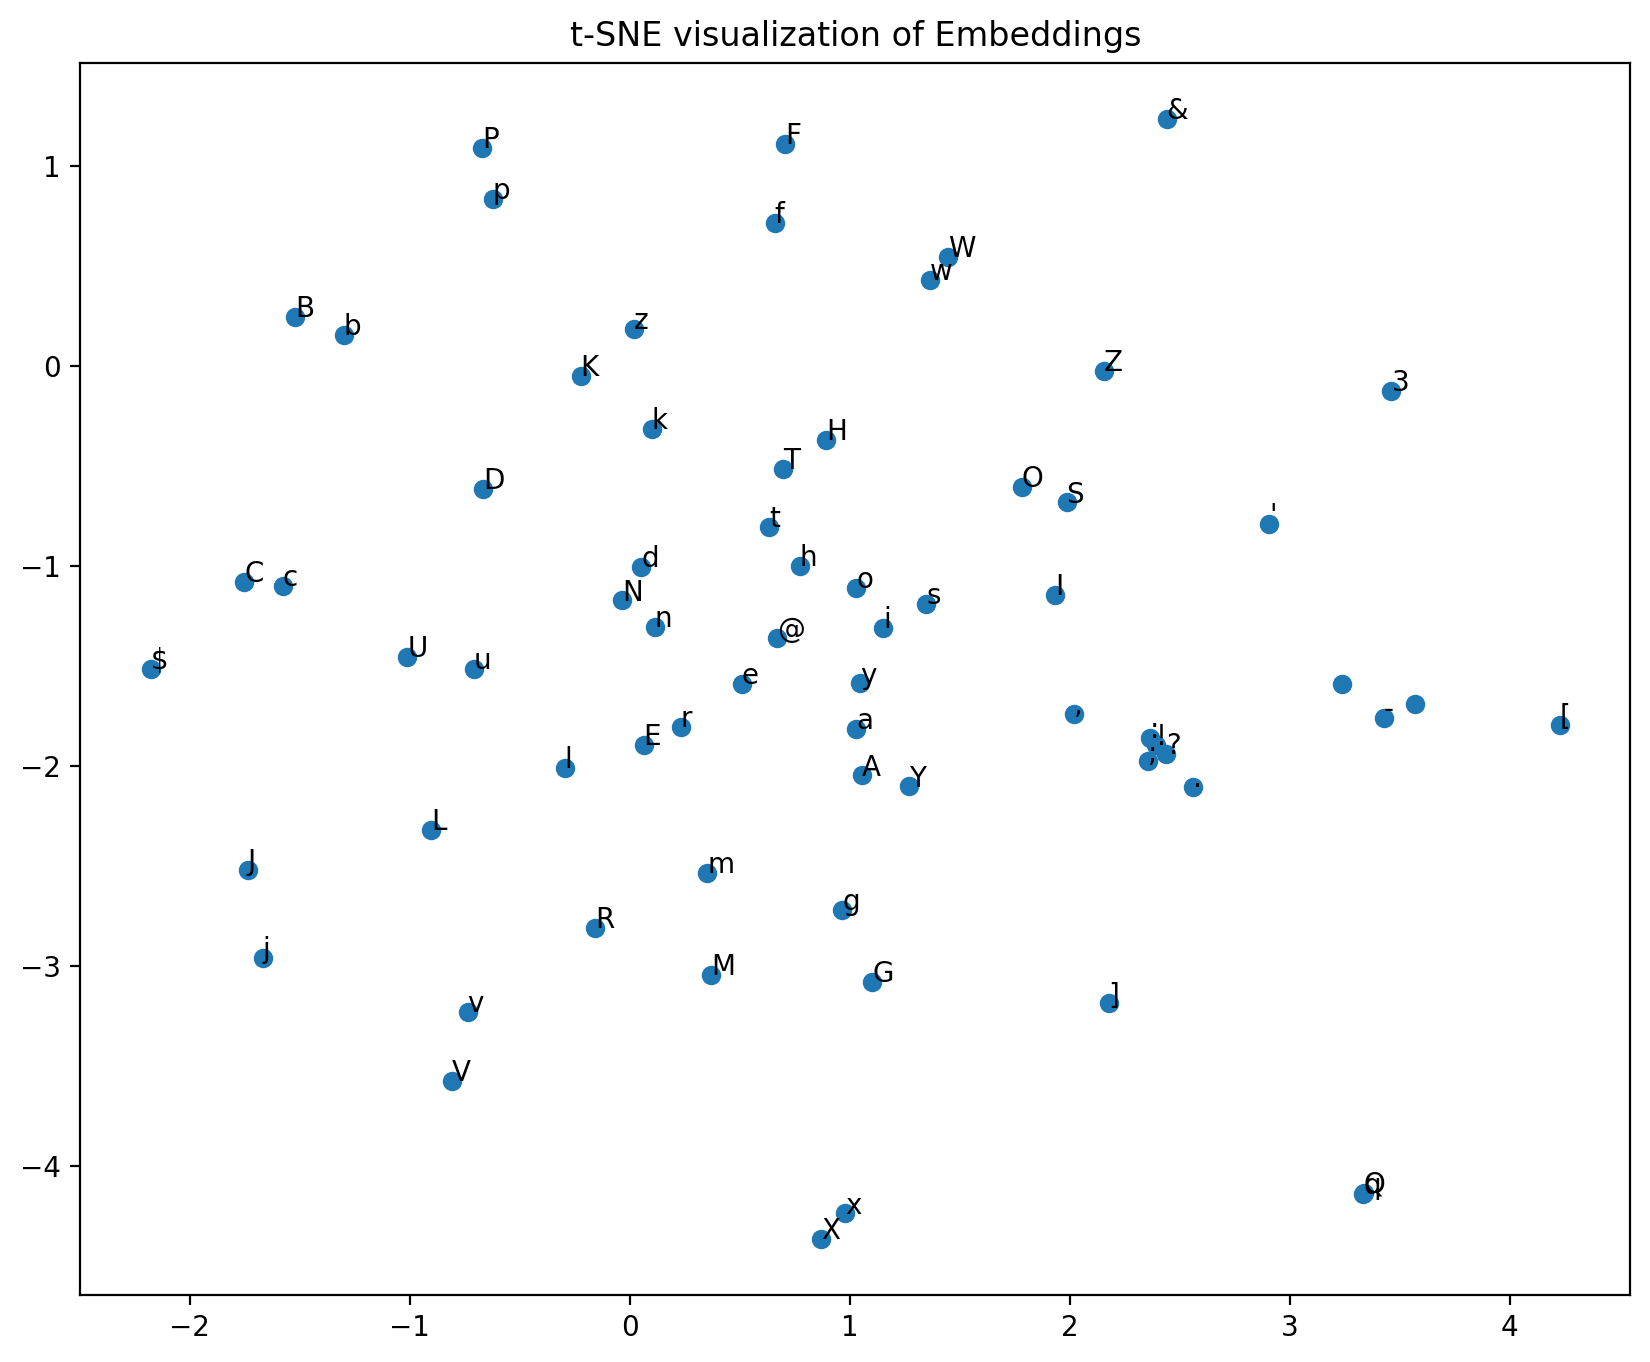

In [ ]:
from sklearn.manifold import TSNE
if model.emb.weight.shape[1] > 2:
    embeddings = model.emb.weight.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i in range(len(itos)):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], itos[i])
    plt.title('t-SNE visualization of Embeddings')
    plt.show()
else:
    embeddings = model.emb.weight.detach().cpu().numpy()
    if embeddings.ndim == 1:
        plt.figure(figsize=(10, 8))
        for i, emb in enumerate(embeddings):
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('1D Visualization of Embeddings')
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        for i in range(len(itos)):
            emb = embeddings[i][0]  # Extracting the single value from the array
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('2D Visualization of Embeddings')
        plt.show()

## Generate text from the model

### Text generated without any seed text

In [ ]:
print(generate_text(model, "", itos, stoi, block_size, 1000))

kintle anvine,
' sponed her's pant, and audient and in it wind,
Where upon the but do give you have yet
Thou the the name of len, and and in blunt well
Against true takeins answer hastorh offer;
But to peace so?
You'lt
And sees raste believe so, some mine meantift mystresheanously
The smeats, there's be me at leap my false meats
Aughter to lise peech! powest the deof,
Anothe earful to prince, usur right to stut:
Cut'd. grievoke conjured his 'fathient broke
That days no manst himself and it for toward,
If they satis.
Troube so court The inquire of my tops.

ARTHUR:
Make thee a plaunded and make the now of?

KING JOHN:
A but no hander with a 
Ay, my fellow felly, so knowor steeter,
Hole:pefyr-fight the do never from you to
Look indincendess as all servant longs,
And to his hear, made holy mercyed; then stame breath
Of on muthaom hath maker me for the dest
And it is safe of England emble alling,
Thou shalt get your they and whey arm loyalt,
I wo old Erminest perm;
Then to was sirma offer 

### Text generated with seed text provided

In [ ]:
inp_str = "We are accounted poor citizens, the patricians"
print(inp_str+generate_text(model, inp_str, itos, stoi, block_size, 1000))

We are accounted poor citizens, the patricians?

SEBASTUS:
I work a may blang be with maniciplew
And depast? audtains up brool that I must my dust
An even forsweet this hath foer; there the bloody not!

SALET QUBSILINIA:
And bleam'd trasp judention. Advail;
We shall tho fatch it of thought of must and all a
ran, be an aussity in advicy him life.

My offended meants thy father spapmine of their,
And friends cold life: out Let to add,
I am glass you says thou constant shall be, bitter.
Heaven trunk, truth, the lay not by him.

Methore
lary?
To forey I would be it, the majesty's well!

KING JOHN:
Now this speaks: it our do no sorrow the Inspen now
To stay some many too.
Ilpeach do houl, with parsaciously dare to go.

Chankit Her.

KING JOHN:
Loay as retor to both! oul love rox bespos.

BASTARD:
With in here hald affend feet a touch. But as no
Thou got fear your malley we command us meant.

MALTOLINE:
Thyself highny and my weal had Sineltle:
Thou saurvesion hawe, man thou stand youph, no m

Text(0.5, 1.0, 'Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers')

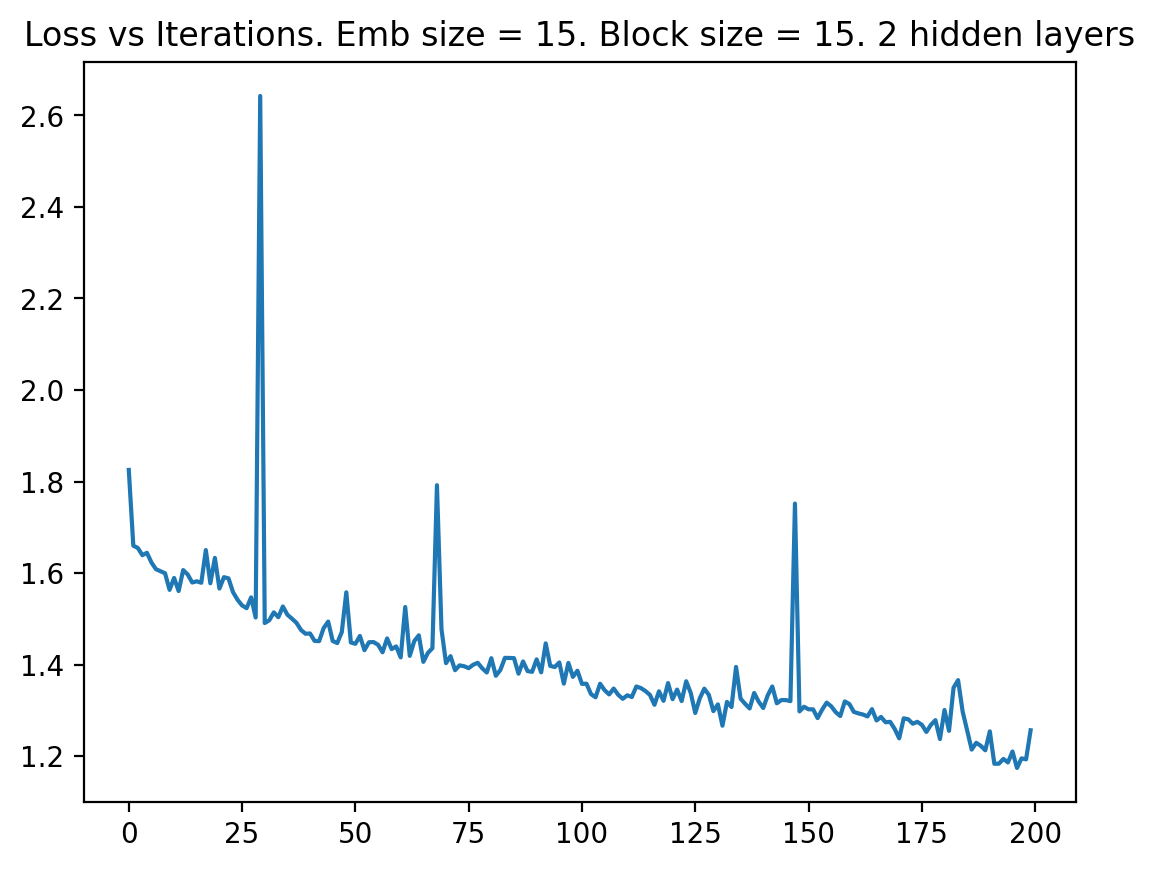

In [ ]:
import numpy as np
plt.plot(np.arange(200),loss_arr)
plt.title("Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers")

# Saving the model

In [ ]:
torch.save(model.state_dict(),"Model_emb"+str(emb_dim)+"_block_size_"+str(block_size)+"_"+ actFuncDict[1] +".pth")

In [ ]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

Tuning Parameters

1. Embedding size
2. Activation Function
3. Context length